<a href="https://colab.research.google.com/github/verma-saloni/Articles/blob/master/tryCopy_of_Hybrid_KNN_model_for_Politifact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First we import the required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_fake = pd.read_csv('/content/drive/MyDrive/politifact_fake.csv')
df_real = pd.read_csv('/content/drive/MyDrive/politifact_real.csv')
df_fake['labelML']=0
df_real['labelML']=1

df_fake.count()


id           432
news_url     428
title        432
tweet_ids    392
labelML      432
dtype: int64

In [ ]:
#df= df_fake.head(10).append(df_real.head(10))
news= df_fake.append(df_real)
news.reset_index(drop=True, inplace=True)

In [ ]:
news.head()

,id,news_url,title,tweet_ids,labelML
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0


In [ ]:
news = news.drop(['tweet_ids', 'news_url','id'], axis=1)
news.count()

title      1056
labelML    1056
dtype: int64

In [ ]:
news

,title,labelML
0,BREAKING: First NFL Team Declares Bankruptcy O...,0
1,Court Orders Obama To Pay $400 Million In Rest...,0
2,UPDATE: Second Roy Moore Accuser Works For Mic...,0
3,Oscar Pistorius Attempts To Commit Suicide,0
4,Trump Votes For Death Penalty For Being Gay,0
...,...,...
1051,Flake: “Religious tests should have no place i...,1
1052,Change We Can Believe In,1
1053,deputy director of national health statistics ...,1
1054,Romneys ProLife Conversion Myth or Reality Jun...,1


In [ ]:
news.dtypes

title      object
labelML     int64
dtype: object

In [ ]:
news['labelML'] = news['labelML'].fillna(0).astype(np.int64)

In [ ]:
news.dtypes

title      object
labelML     int64
dtype: object

In [ ]:
news.count()

title      1056
labelML    1056
dtype: int64

In [ ]:
news.head()

,title,labelML
0,BREAKING: First NFL Team Declares Bankruptcy O...,0
1,Court Orders Obama To Pay $400 Million In Rest...,0
2,UPDATE: Second Roy Moore Accuser Works For Mic...,0
3,Oscar Pistorius Attempts To Commit Suicide,0
4,Trump Votes For Death Penalty For Being Gay,0


In [ ]:
import nltk
nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
news['title']= news['title'].apply(denoise_text)


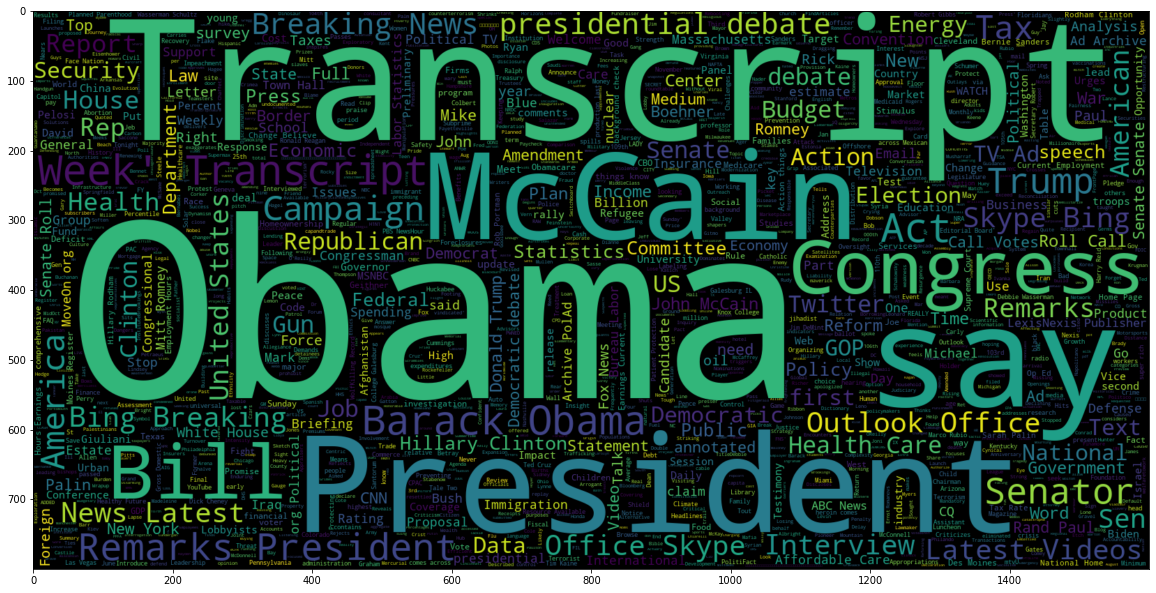

In [ ]:
#WORDCLOUD FOR REAL TEXT (LABEL - 1)
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news[news.labelML == 1].title))
plt.imshow(wc , interpolation = 'bilinear')

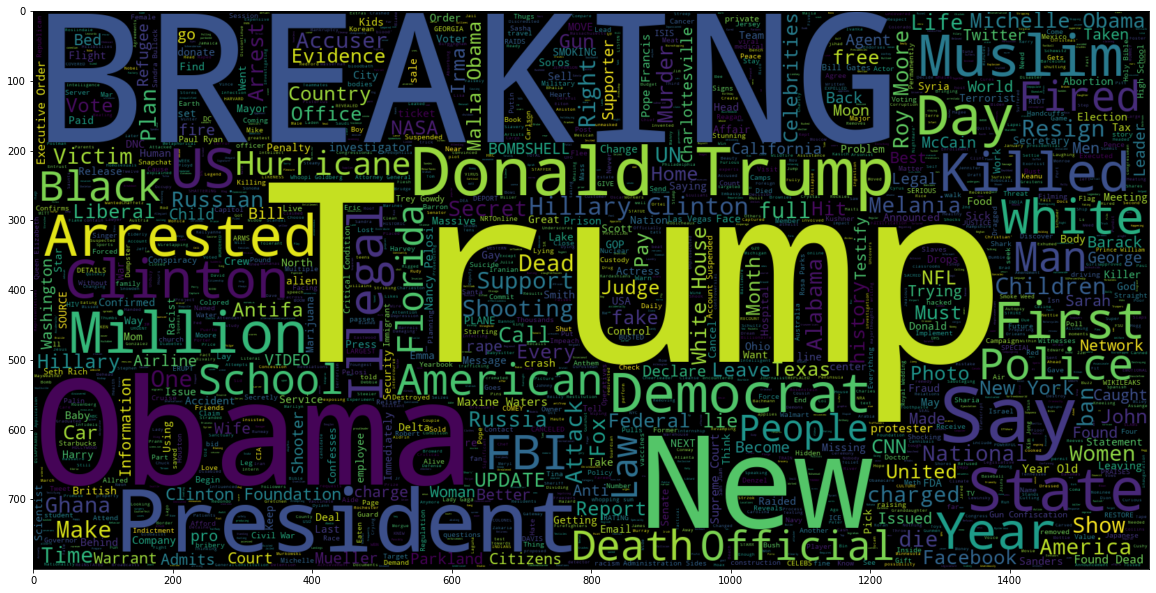

In [ ]:
#WORDCLOUD FOR Fake TEXT (LABEL - 0)
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news[news.labelML == 0].title))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
#Splitting the data into 2 parts - training and testing data
x_train,x_test,y_train,y_test = train_test_split(news.title,news.labelML,test_size=0.1,random_state=42)
max_features = 10000
maxlen = 300

In [ ]:
#Tokenizing Text -> Repsesenting each word by a number
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
#Glove
EMBEDDING_FILE = '/content/drive/MyDrive/glove.6B.50d.txt'

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
embedding_matrix

array([[ 0.90974054, -0.37215425,  0.91463694, ...,  0.94399495,
         0.40820898, -1.12892249],
       [-0.40999136, -0.17133105,  0.19371945, ...,  0.45414828,
         0.19892996, -0.7543342 ],
       [-0.15869079,  0.15228275, -0.69812893, ...,  0.26375672,
        -0.57259779, -0.16568505],
       ...,
       [-0.15562759,  0.61941358,  1.00500856, ..., -0.88761202,
         0.73980231, -0.34197395],
       [ 0.46329078,  0.11309962,  0.5837788 , ...,  0.46330118,
        -1.02812182,  0.0213034 ],
       [ 1.02362166,  0.89443022,  1.44809473, ..., -0.3007305 ,
        -0.43576027,  0.45354332]])

In [ ]:
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector


In [ ]:

batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
#Defining Neural Network
# model = Sequential()
#Non-trainable embeddidng layer
# model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
# model.add(LSTM(units=128 , return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=64))
# model.add(Dropout(0.1))
# model.add(Dense(units = 32 , activation = 'relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Hybrid Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=, output_dim=embed_size, weights=[embedding_matrix],trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

ValueError: ignored

In [ ]:
model.summary()

In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = model.predict_classes(X_test)
pred[:5]

In [ ]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

In [ ]:
cm = confusion_matrix(y_test,pred)
cm

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Not Fake'] , columns = ['Fake','Not Fake'])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Not Fake'] , yticklabels = ['Fake','Not Fake'])

In [ ]:
sentence = ["All the universities and schools remain closed for two months due to the corona virus outbreak in the country."]
sequences = tokenizer.texts_to_sequences(sentence)
padded = sequence.pad_sequences(sequences, maxlen=maxlen)
print(model.predict(padded))

In [ ]:
import multiprocessing

import nltk
from gensim.models import Word2Vec
from nltk.corpus import brown

# Data is processed and Tokenised!
#sentences = brown.sents()
#print(sentences[:3])

EMB_DIM = 300

w2v = Word2Vec(news.title, size=EMB_DIM, window=5, min_count=5, negative=15, iter=10,
               workers=multiprocessing.cpu_count())

word_vectors = w2v.wv  # get trained embeddings - an KeyedVector instaces
#result = word_vectors.similar_by_word("Saturday")
#print("Most Similar to 'Saturday': %s" % result[:3])